<a href="https://colab.research.google.com/github/lsh3163/Cifar10Tutorial/blob/master/week9_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week9_1 : Cifar 10 Resnet 이용하여 학습(Pytorch)

In [1]:
import torch
from torchvision import datasets, transforms
from torch import nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# CUDA 기기가 존재한다면, 아래 코드가 CUDA 장치를 출력합니다:

print(device)

cuda:0


## trainloader / testloader 정의

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
# Download and load the training data
trainset = datasets.CIFAR10('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.CIFAR10('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Load Pretrained Resnet 50

In [4]:
from torchvision import datasets, transforms, models
model = models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [5]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 10),
                                 nn.LogSoftmax(dim=1))
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

## Train

In [6]:
epochs=30
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # 0으로 초기화
        optimizer.zero_grad()
        # log_ps-> 확률값
        log_ps = model(images.to(device))
        # 손실계산
        loss = criterion(log_ps, labels.to(device))
        loss.backward()
        optimizer.step()
        
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            # test 과정에 들어간다. dropout을 안하게 된다.
            # 정확하게 말하면, dropout 하는 비율이 0이 된다.
            model.eval()
            for images, labels in testloader:
                log_ps = model(images.to(device))
                test_loss += criterion(log_ps, labels.to(device))
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.to(device).view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        # 다시 트레이닝 과정으로 돌아간다.
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))


Epoch: 1/30..  Training Loss: 1.707..  Test Loss: 1.552..  Test Accuracy: 0.456
Epoch: 2/30..  Training Loss: 1.570..  Test Loss: 1.483..  Test Accuracy: 0.475
Epoch: 3/30..  Training Loss: 1.535..  Test Loss: 1.431..  Test Accuracy: 0.495
Epoch: 4/30..  Training Loss: 1.507..  Test Loss: 1.458..  Test Accuracy: 0.492
Epoch: 5/30..  Training Loss: 1.488..  Test Loss: 1.416..  Test Accuracy: 0.503
Epoch: 6/30..  Training Loss: 1.473..  Test Loss: 1.398..  Test Accuracy: 0.514
Epoch: 7/30..  Training Loss: 1.459..  Test Loss: 1.415..  Test Accuracy: 0.503
Epoch: 8/30..  Training Loss: 1.451..  Test Loss: 1.398..  Test Accuracy: 0.516
Epoch: 9/30..  Training Loss: 1.441..  Test Loss: 1.411..  Test Accuracy: 0.508
Epoch: 10/30..  Training Loss: 1.427..  Test Loss: 1.353..  Test Accuracy: 0.528
Epoch: 11/30..  Training Loss: 1.430..  Test Loss: 1.372..  Test Accuracy: 0.524
Epoch: 12/30..  Training Loss: 1.417..  Test Loss: 1.375..  Test Accuracy: 0.520
Epoch: 13/30..  Training Loss: 1.413.

## Plot Loss

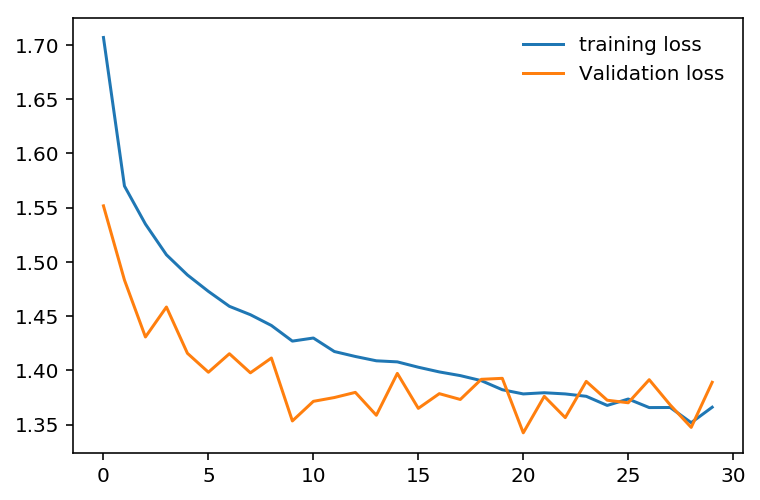

In [7]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)